# Notebook Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np
from matplotlib.patches import Ellipse
import streamlit as st
import pandas as pd
import plotly.express as px
from scipy.stats import zscore
from mplsoccer import VerticalPitch

pd.set_option('display.max_columns', None)

# Data Wrangling

In [2]:
from understatapi import UnderstatClient

with UnderstatClient() as understat:
    league_player_data = understat.league(league="EPL").get_player_data(season="2025")
    player_shot_data = understat.player(player="1250").get_shot_data()
    team_match_data = understat.team(team="Arsenal").get_match_data(season="2025")
    roster_data = understat.match(match="14711").get_roster_data()

In [4]:
import pandas as pd

# Assuming team_match_data is already defined
team_match_data_df = pd.json_normalize(
    team_match_data,
    sep='_'
)

# Optional: convert types where appropriate
team_match_data_df['datetime'] = pd.to_datetime(team_match_data_df['datetime'])
team_match_data_df['goals_h'] = pd.to_numeric(team_match_data_df['goals_h'], errors='coerce')
team_match_data_df['goals_a'] = pd.to_numeric(team_match_data_df['goals_a'], errors='coerce')
team_match_data_df['xG_h'] = pd.to_numeric(team_match_data_df['xG_h'], errors='coerce')
team_match_data_df['xG_a'] = pd.to_numeric(team_match_data_df['xG_a'], errors='coerce')

team_match_data_df.head()


,id,isResult,side,datetime,result,h_id,h_title,h_short_title,a_id,a_title,a_short_title,goals_h,goals_a,xG_h,xG_a,forecast_w,forecast_d,forecast_l
0,26604,True,h,2024-08-17 14:00:00,w,83,Arsenal,ARS,229,Wolverhampton Wanderers,WOL,2,0,1.628300,0.575835,0.631065,0.240743,0.128192
1,26618,True,a,2024-08-24 16:30:00,w,71,Aston Villa,AVL,83,Arsenal,ARS,0,2,1.316640,1.413990,0.349613,0.256147,0.394240
2,26622,True,h,2024-08-31 11:30:00,d,83,Arsenal,ARS,220,Brighton,BRI,1,1,2.417980,1.817480,0.514887,0.193318,0.291795
3,26640,True,a,2024-09-15 13:00:00,w,82,Tottenham,TOT,83,Arsenal,ARS,0,1,0.792595,1.120900,0.257516,0.310820,0.431665
4,26651,True,a,2024-09-22 15:30:00,d,88,Manchester City,MCI,83,Arsenal,ARS,2,2,2.755880,1.284110,0.682943,0.162175,0.154882


In [6]:
team_names = team_match_data_df['h_title'].unique()
print(team_names)

['Arsenal' 'Aston Villa' 'Tottenham' 'Manchester City' 'Bournemouth'
 'Newcastle United' 'Chelsea' 'West Ham' 'Fulham' 'Crystal Palace'
 'Brentford' 'Brighton' 'Wolverhampton Wanderers' 'Leicester'
 'Nottingham Forest' 'Manchester United' 'Everton' 'Ipswich' 'Liverpool'
 'Southampton']


In [9]:
import pandas as pd
import logging

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

all_match_data = []

for i, team in enumerate(team_names, 1):
    try:
        logging.info(f"[{i}/{len(team_names)}] Fetching match data for team: {team}")
        match_data = understat.team(team=team).get_match_data(season="2025")
        df = pd.json_normalize(match_data, sep='_')
        df['team'] = team  # tag origin team
        all_match_data.append(df)
    except Exception as e:
        logging.error(f"Error fetching match data for {team}: {e}")

# Combine into one DataFrame
team_match_data_df = pd.concat(all_match_data, ignore_index=True)

# Drop duplicates by match ID
team_match_data_df = team_match_data_df.drop_duplicates(subset='id', keep='first')

# Optional: convert datetime column
team_match_data_df['datetime'] = pd.to_datetime(team_match_data_df['datetime'])

# Final output
print(f"Final match data shape: {team_match_data_df.shape}")
team_match_data_df.head()


2025-05-29 09:15:30,469 - INFO - [1/20] Fetching match data for team: Arsenal
2025-05-29 09:15:30,659 - INFO - [2/20] Fetching match data for team: Aston Villa
2025-05-29 09:15:30,776 - INFO - [3/20] Fetching match data for team: Tottenham
2025-05-29 09:15:30,902 - INFO - [4/20] Fetching match data for team: Manchester City
2025-05-29 09:15:31,015 - INFO - [5/20] Fetching match data for team: Bournemouth
2025-05-29 09:15:31,154 - INFO - [6/20] Fetching match data for team: Newcastle United
2025-05-29 09:15:31,294 - INFO - [7/20] Fetching match data for team: Chelsea
2025-05-29 09:15:31,411 - INFO - [8/20] Fetching match data for team: West Ham
2025-05-29 09:15:31,534 - INFO - [9/20] Fetching match data for team: Fulham
2025-05-29 09:15:31,647 - INFO - [10/20] Fetching match data for team: Crystal Palace
2025-05-29 09:15:31,763 - INFO - [11/20] Fetching match data for team: Brentford
2025-05-29 09:15:31,882 - INFO - [12/20] Fetching match data for team: Brighton
2025-05-29 09:15:31,995 

Final match data shape: (380, 19)


,id,isResult,side,datetime,result,h_id,h_title,h_short_title,a_id,a_title,a_short_title,goals_h,goals_a,xG_h,xG_a,forecast_w,forecast_d,forecast_l,team
0,26604,True,h,2024-08-17 14:00:00,w,83,Arsenal,ARS,229,Wolverhampton Wanderers,WOL,2,0,1.6283,0.575835,0.631065,0.240743,0.128192,Arsenal
1,26618,True,a,2024-08-24 16:30:00,w,71,Aston Villa,AVL,83,Arsenal,ARS,0,2,1.31664,1.41399,0.349613,0.256147,0.394240,Arsenal
2,26622,True,h,2024-08-31 11:30:00,d,83,Arsenal,ARS,220,Brighton,BRI,1,1,2.41798,1.81748,0.514887,0.193318,0.291795,Arsenal
3,26640,True,a,2024-09-15 13:00:00,w,82,Tottenham,TOT,83,Arsenal,ARS,0,1,0.792595,1.1209,0.257516,0.310820,0.431665,Arsenal
4,26651,True,a,2024-09-22 15:30:00,d,88,Manchester City,MCI,83,Arsenal,ARS,2,2,2.75588,1.28411,0.682943,0.162175,0.154882,Arsenal


In [11]:

# Create DataFrame
league_player_data_pd = pd.DataFrame(league_player_data)

# Convert numeric columns that are currently strings to appropriate numeric types
numeric_cols = ['games', 'time', 'goals', 'xG', 'assists', 'xA', 'shots', 'key_passes',
                'yellow_cards', 'red_cards', 'npg', 'npxG', 'xGChain', 'xGBuildup']

for col in numeric_cols:
    if col in league_player_data_pd.columns:
        league_player_data_pd[col] = pd.to_numeric(league_player_data_pd[col], errors='coerce')

league_player_data_pd

,id,player_name,games,time,goals,xG,assists,xA,shots,key_passes,yellow_cards,red_cards,position,team_title,npg,npxG,xGChain,xGBuildup
0,1250,Mohamed Salah,38,3392,29,27.706267,18,15.858334,130,89,1,0,F M,Liverpool,20,20.855748,48.535889,16.206758
1,5232,Alexander Isak,34,2822,23,22.356988,6,5.448704,99,42,1,0,F,Newcastle United,19,19.312313,26.209551,3.579238
2,8260,Erling Haaland,31,2749,22,23.954593,3,3.581227,109,29,2,0,F,Manchester City,19,20.909917,22.845246,3.535369
3,4456,Chris Wood,36,3024,20,15.638655,3,3.044111,68,22,1,0,F S,Nottingham Forest,17,13.355148,14.720165,1.669209
4,6552,Bryan Mbeumo,38,3419,20,13.632161,7,10.376489,86,70,3,0,D F M,Brentford,15,9.065148,24.377113,9.351835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557,13586,Olabade Aluko,1,1,0,0.000000,0,0.000000,0,0,0,0,S,Leicester,0,0.000000,0.000000,0.000000
558,13588,Gustavo Nunes,3,8,0,0.000000,0,0.000000,0,0,0,0,S,Brentford,0,0.000000,0.000000,0.000000
559,13606,Michael Golding,1,1,0,0.000000,0,0.000000,0,0,0,0,S,Leicester,0,0.000000,0.000000,0.000000
560,13636,Joachim Kayi-Sanda,2,9,0,0.000000,0,0.000000,0,0,0,0,S,Southampton,0,0.000000,0.136087,0.136087


In [12]:
import pandas as pd

all_shots = []

for player_id in league_player_data_pd['id']:
    try:
        shots = understat.player(player=str(player_id)).get_shot_data()
        df_shots = pd.DataFrame(shots)
        df_shots['player_id'] = player_id  # keep track of player ID
        all_shots.append(df_shots)
    except Exception as e:
        print(f"Error fetching shots for player {player_id}: {e}")

# Combine all shots into a single DataFrame
all_shots_df = pd.concat(all_shots, ignore_index=True)

all_shots_df


,id,minute,result,X,Y,xG,player,h_a,player_id,situation,season,shotType,match_id,h_team,a_team,h_goals,a_goals,date,player_assisted,lastAction
0,15217,92,MissedShots,0.8230000305175781,0.36900001525878906,0.0623646005988121,Mohamed Salah,h,1250,OpenPlay,2014,LeftFoot,4720,Chelsea,Swansea,4,2,2014-09-13 15:00:00,Eden Hazard,Pass
1,20034,84,SavedShot,0.92,0.5320000076293945,0.4399380087852478,Mohamed Salah,a,1250,OpenPlay,2014,LeftFoot,4560,Tottenham,Chelsea,5,3,2015-01-01 17:30:00,Eden Hazard,Pass
2,46908,87,BlockedShot,0.8859999847412109,0.5659999847412109,0.09675999730825424,Mohamed Salah,h,1250,OpenPlay,2014,LeftFoot,4929,Fiorentina,Atalanta,3,2,2015-02-08 11:30:00,Mario Gomez,BallTouch
3,47192,0,SavedShot,0.9640000152587891,0.6880000305175781,0.049131400883197784,Mohamed Salah,a,1250,OpenPlay,2014,LeftFoot,4937,Sassuolo,Fiorentina,1,3,2015-02-14 17:00:00,David Pizarro,Chipped
4,47197,16,MissedShots,0.9,0.6769999694824219,0.06032019853591919,Mohamed Salah,a,1250,OpenPlay,2014,LeftFoot,4937,Sassuolo,Fiorentina,1,3,2015-02-14 17:00:00,Khouma Babacar,Pass
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62358,619436,89,SavedShot,0.9369999694824219,0.5829999923706055,0.025054186582565308,Shumaira Mheuka,h,13476,FromCorner,2024,Head,26869,Chelsea,Southampton,4,0,2025-02-25 20:15:00,Cole Palmer,Aerial
62359,633481,95,MissedShots,0.7959999847412109,0.2570000076293945,0.021105527877807617,Jeremy Monga,a,13579,OpenPlay,2024,LeftFoot,26958,Nottingham Forest,Leicester,2,2,2025-05-11 13:15:00,Wilfred Ndidi,Pass
62360,633483,96,SavedShot,0.8280000305175781,0.46900001525878904,0.11372292041778564,Jeremy Monga,a,13579,OpenPlay,2024,LeftFoot,26958,Nottingham Forest,Leicester,2,2,2025-05-11 13:15:00,None,Dispossessed
62361,635093,82,BlockedShot,0.8690000152587891,0.6659999847412109,0.07232024520635605,Jeremy Monga,h,13579,OpenPlay,2024,LeftFoot,26969,Leicester,Ipswich,2,0,2025-05-18 14:00:00,Bilal El Khannouss,Pass


In [13]:
filtered_shots_df = all_shots_df[all_shots_df['match_id'].isin(team_match_data_df['id'])]
filtered_shots_df

,id,minute,result,X,Y,xG,player,h_a,player_id,situation,season,shotType,match_id,h_team,a_team,h_goals,a_goals,date,player_assisted,lastAction
1099,584693,46,BlockedShot,0.874000015258789,0.33799999237060546,0.0402679517865181,Mohamed Salah,a,1250,FromCorner,2024,LeftFoot,26603,Ipswich,Liverpool,0,2,2024-08-17 11:30:00,Luis Díaz,Pass
1100,584700,64,Goal,0.9369999694824219,0.4490000152587891,0.5713244676589966,Mohamed Salah,a,1250,OpenPlay,2024,LeftFoot,26603,Ipswich,Liverpool,0,2,2024-08-17 11:30:00,None,None
1101,584702,70,SavedShot,0.8369999694824218,0.5629999923706055,0.40319985151290894,Mohamed Salah,a,1250,OpenPlay,2024,LeftFoot,26603,Ipswich,Liverpool,0,2,2024-08-17 11:30:00,Dominik Szoboszlai,Throughball
1102,584707,93,SavedShot,0.9309999847412109,0.34700000762939454,0.08194273710250854,Mohamed Salah,a,1250,OpenPlay,2024,LeftFoot,26603,Ipswich,Liverpool,0,2,2024-08-17 11:30:00,None,None
1103,586849,20,MissedShots,0.8819999694824219,0.3139999961853027,0.06441381573677063,Mohamed Salah,h,1250,OpenPlay,2024,LeftFoot,26621,Liverpool,Brentford,2,0,2024-08-25 15:30:00,Trent Alexander-Arnold,Pass
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62358,619436,89,SavedShot,0.9369999694824219,0.5829999923706055,0.025054186582565308,Shumaira Mheuka,h,13476,FromCorner,2024,Head,26869,Chelsea,Southampton,4,0,2025-02-25 20:15:00,Cole Palmer,Aerial
62359,633481,95,MissedShots,0.7959999847412109,0.2570000076293945,0.021105527877807617,Jeremy Monga,a,13579,OpenPlay,2024,LeftFoot,26958,Nottingham Forest,Leicester,2,2,2025-05-11 13:15:00,Wilfred Ndidi,Pass
62360,633483,96,SavedShot,0.8280000305175781,0.46900001525878904,0.11372292041778564,Jeremy Monga,a,13579,OpenPlay,2024,LeftFoot,26958,Nottingham Forest,Leicester,2,2,2025-05-11 13:15:00,None,Dispossessed
62361,635093,82,BlockedShot,0.8690000152587891,0.6659999847412109,0.07232024520635605,Jeremy Monga,h,13579,OpenPlay,2024,LeftFoot,26969,Leicester,Ipswich,2,0,2025-05-18 14:00:00,Bilal El Khannouss,Pass


# Load Data

In [ ]:
all_shots_df.to_pickle('all_shots_df.pkl')
filtered_shots_df.to_pickle('filtered_shots_df.pkl')
team_match_data_df.to_pickle('team_match_data_df.pkl')

In [ ]:
all_shots_df = pd.read_pickle('all_shots_df.pkl')
filtered_shots_df = pd.read_pickle('filtered_shots_df.pkl')
team_match_data_df = pd.read_pickle('team_match_data_df.pkl')

In [15]:
filtered_shots_df

,id,minute,result,X,Y,xG,player,h_a,player_id,situation,season,shotType,match_id,h_team,a_team,h_goals,a_goals,date,player_assisted,lastAction
1099,584693,46,BlockedShot,0.874000015258789,0.33799999237060546,0.0402679517865181,Mohamed Salah,a,1250,FromCorner,2024,LeftFoot,26603,Ipswich,Liverpool,0,2,2024-08-17 11:30:00,Luis Díaz,Pass
1100,584700,64,Goal,0.9369999694824219,0.4490000152587891,0.5713244676589966,Mohamed Salah,a,1250,OpenPlay,2024,LeftFoot,26603,Ipswich,Liverpool,0,2,2024-08-17 11:30:00,None,None
1101,584702,70,SavedShot,0.8369999694824218,0.5629999923706055,0.40319985151290894,Mohamed Salah,a,1250,OpenPlay,2024,LeftFoot,26603,Ipswich,Liverpool,0,2,2024-08-17 11:30:00,Dominik Szoboszlai,Throughball
1102,584707,93,SavedShot,0.9309999847412109,0.34700000762939454,0.08194273710250854,Mohamed Salah,a,1250,OpenPlay,2024,LeftFoot,26603,Ipswich,Liverpool,0,2,2024-08-17 11:30:00,None,None
1103,586849,20,MissedShots,0.8819999694824219,0.3139999961853027,0.06441381573677063,Mohamed Salah,h,1250,OpenPlay,2024,LeftFoot,26621,Liverpool,Brentford,2,0,2024-08-25 15:30:00,Trent Alexander-Arnold,Pass
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62358,619436,89,SavedShot,0.9369999694824219,0.5829999923706055,0.025054186582565308,Shumaira Mheuka,h,13476,FromCorner,2024,Head,26869,Chelsea,Southampton,4,0,2025-02-25 20:15:00,Cole Palmer,Aerial
62359,633481,95,MissedShots,0.7959999847412109,0.2570000076293945,0.021105527877807617,Jeremy Monga,a,13579,OpenPlay,2024,LeftFoot,26958,Nottingham Forest,Leicester,2,2,2025-05-11 13:15:00,Wilfred Ndidi,Pass
62360,633483,96,SavedShot,0.8280000305175781,0.46900001525878904,0.11372292041778564,Jeremy Monga,a,13579,OpenPlay,2024,LeftFoot,26958,Nottingham Forest,Leicester,2,2,2025-05-11 13:15:00,None,Dispossessed
62361,635093,82,BlockedShot,0.8690000152587891,0.6659999847412109,0.07232024520635605,Jeremy Monga,h,13579,OpenPlay,2024,LeftFoot,26969,Leicester,Ipswich,2,0,2025-05-18 14:00:00,Bilal El Khannouss,Pass


In [16]:
team_match_data_df

,id,isResult,side,datetime,result,h_id,h_title,h_short_title,a_id,a_title,a_short_title,goals_h,goals_a,xG_h,xG_a,forecast_w,forecast_d,forecast_l,team
0,26604,True,h,2024-08-17 14:00:00,w,83,Arsenal,ARS,229,Wolverhampton Wanderers,WOL,2,0,1.6283,0.575835,0.631065,0.240743,0.128192,Arsenal
1,26618,True,a,2024-08-24 16:30:00,w,71,Aston Villa,AVL,83,Arsenal,ARS,0,2,1.31664,1.41399,0.349613,0.256147,0.394240,Arsenal
2,26622,True,h,2024-08-31 11:30:00,d,83,Arsenal,ARS,220,Brighton,BRI,1,1,2.41798,1.81748,0.514887,0.193318,0.291795,Arsenal
3,26640,True,a,2024-09-15 13:00:00,w,82,Tottenham,TOT,83,Arsenal,ARS,0,1,0.792595,1.1209,0.257516,0.310820,0.431665,Arsenal
4,26651,True,a,2024-09-22 15:30:00,d,88,Manchester City,MCI,83,Arsenal,ARS,2,2,2.75588,1.28411,0.682943,0.162175,0.154882,Arsenal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
650,26643,True,a,2024-09-21 14:00:00,d,74,Southampton,SOU,285,Ipswich,IPS,1,1,2.89813,1.645,0.634958,0.165477,0.199564,Ipswich
668,26827,True,a,2025-01-25 15:00:00,l,87,Liverpool,LIV,285,Ipswich,IPS,4,1,2.16809,0.804707,0.686247,0.187779,0.125973,Ipswich
669,26837,True,h,2025-02-01 15:00:00,l,285,Ipswich,IPS,74,Southampton,SOU,1,2,1.94845,1.17566,0.553458,0.219393,0.227148,Ipswich
695,26721,True,a,2024-11-24 14:00:00,w,74,Southampton,SOU,87,Liverpool,LIV,2,3,1.53985,3.18835,0.154503,0.145541,0.699955,Liverpool


In [31]:
print("Min X:", all_shots_df['X'].min())
print("Max X:", all_shots_df['X'].max())


Min X: 0.004000000059604645
Max X: 0.999000015258789


In [18]:
print("Min Y:", all_shots_df['Y'].min())
print("Max Y:", all_shots_df['Y'].max())

Min Y: 0.00800000011920929
Max Y: 0.995


# Functions

In [18]:
def plot_player_shots(player_name, all_shots_df, player_number=1):
    """
    Plots the shot map for a specific player on a half-pitch using StatsBomb dimensions,
    with color depending on player number (Player 1: blue, Player 2: red).
    """

    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from mplsoccer import VerticalPitch
    from matplotlib.lines import Line2D

    # Ensure 'date' column is datetime
    all_shots_df['date'] = pd.to_datetime(all_shots_df['date'], errors='coerce')

    # Filter by date range
    start_date = pd.Timestamp('2024-08-16')
    end_date = pd.Timestamp('2025-05-27')
    date_filtered = all_shots_df[(all_shots_df['date'] >= start_date) & (all_shots_df['date'] <= end_date)]

    # Filter the data for the selected player
    player_shots = date_filtered[date_filtered['player'] == player_name].copy()

    if player_shots.empty:
        print(f"No shots found for player: {player_name} in the specified date range.")
        return

    # Convert to numeric and scale to StatsBomb dimensions
    player_shots['X'] = pd.to_numeric(player_shots['X'], errors='coerce') * 120
    player_shots['Y'] = pd.to_numeric(player_shots['Y'], errors='coerce') * 80
    player_shots['Y'] = 80 - player_shots['Y']

    # Convert xG to numeric and set minimum size for visibility
    player_shots['xG'] = pd.to_numeric(player_shots['xG'], errors='coerce').fillna(0)
    min_size = 50
    sizes = np.clip(player_shots['xG'] * 1000, min_size, None)

    # Drop any rows with NaNs after conversion
    player_shots.dropna(subset=['X', 'Y'], inplace=True)

    # Create half-pitch
    pitch = VerticalPitch(pitch_type='statsbomb', half=True, pitch_color='#262730')
    fig, ax = pitch.draw(figsize=(10, 10))

    # Separate goal and non-goal shots
    goal_shots = player_shots[player_shots['result'] == 'Goal']
    non_goal_shots = player_shots[player_shots['result'] != 'Goal']

    goal_sizes = sizes[goal_shots.index]
    non_goal_sizes = sizes[non_goal_shots.index]

    # Set colors by player number
    if player_number == 1:
        goal_facecolor = (0, 0, 1, 0.2)  # Blue with alpha
        goal_edgecolor = 'blue'
    else:
        goal_facecolor = (1, 0, 0, 0.2)  # Red with alpha
        goal_edgecolor = 'red'

    # Plot non-goal shots (black)
    pitch.scatter(
        non_goal_shots['X'], 
        non_goal_shots['Y'], 
        s=non_goal_sizes,
        facecolors=(0, 0, 0, 0.2),
        edgecolors='black',
        linewidth=2,
        ax=ax,
        zorder=2
    )

    # Plot goal shots (color by player)
    pitch.scatter(
        goal_shots['X'], 
        goal_shots['Y'], 
        s=goal_sizes,
        facecolors=goal_facecolor,
        edgecolors=goal_edgecolor,
        linewidth=2,
        ax=ax,
        zorder=3
    )

    # Legend
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Goal',
               markerfacecolor='none', markeredgecolor=goal_edgecolor, markersize=10, linewidth=2),
        Line2D([0], [0], marker='o', color='w', label='Shot (no goal)',
               markerfacecolor='none', markeredgecolor='black', markersize=10, linewidth=2)
    ]

    sample_xG = [0.05, 0.3, 0.7]
    sample_sizes = np.clip(np.array(sample_xG) * 1000, min_size, None)
    for xg_val, size in zip(sample_xG, sample_sizes):
        legend_elements.append(
            Line2D([0], [0], marker='o', linestyle='None',
                   markerfacecolor='gray', markeredgecolor='gray',
                   label=f"xG = {xg_val}", markersize=np.sqrt(size)/2)
        )

    ax.legend(handles=legend_elements, loc='upper right', frameon=True, fontsize=10)

    # Player name label
    ax.text(40, 65, player_name, ha='center', va='center', fontsize=50, fontweight='bold', color='black', alpha=0.5)

    return fig

In [29]:
def plot_match_shots_dual_separate(all_shots_df, h_team, a_team):
    """
    Filters shots for a specific match between home and away teams,
    and plots two separate half-pitch shot maps:
    - Home shots in blue
    - Away shots in red
    """
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from mplsoccer import VerticalPitch
    from matplotlib.lines import Line2D

    # Normalize team names (strip whitespace)
    all_shots_df['h_team'] = all_shots_df['h_team'].str.strip()
    all_shots_df['a_team'] = all_shots_df['a_team'].str.strip()

    # Filter shots from the exact match
    match_shots = all_shots_df[
        (all_shots_df['h_team'] == h_team) & (all_shots_df['a_team'] == a_team)
    ].copy()

    if match_shots.empty:
        print(f"No shots found for match: {h_team} vs {a_team}")
        return

    # Convert coordinates and xG
    match_shots['X'] = pd.to_numeric(match_shots['X'], errors='coerce') * 120
    match_shots['Y'] = pd.to_numeric(match_shots['Y'], errors='coerce') * 80
    match_shots['Y'] = 80 - match_shots['Y']  # flip Y for plotting
    match_shots['xG'] = pd.to_numeric(match_shots['xG'], errors='coerce').fillna(0)

    # Drop NaNs in coordinates
    match_shots.dropna(subset=['X', 'Y'], inplace=True)

    # Separate home and away shots
    home_shots = match_shots[match_shots['h_a'] == 'h']
    away_shots = match_shots[match_shots['h_a'] == 'a']

    # Set sizes by xG (scaled)
    min_size = 50
    home_sizes = np.clip(home_shots['xG'] * 1000, min_size, None)
    away_sizes = np.clip(away_shots['xG'] * 1000, min_size, None)

    pitch = VerticalPitch(pitch_type='statsbomb', half=True, pitch_color='#262730')

    # Plot home shots
    fig1, ax1 = plt.subplots(figsize=(10, 10))
    pitch.draw(ax=ax1)
    pitch.scatter(
        home_shots['X'],
        home_shots['Y'],
        s=home_sizes,
        facecolors=(0, 0, 1, 0.3),
        edgecolors='blue',
        linewidth=2,
        ax=ax1,
        zorder=2
    )
    ax1.set_title(f"{h_team} Shots", fontsize=16, color='white')

    # Plot away shots
    fig2, ax2 = plt.subplots(figsize=(10, 10))
    pitch.draw(ax=ax2)
    pitch.scatter(
        away_shots['X'],
        away_shots['Y'],
        s=away_sizes,
        facecolors=(1, 0, 0, 0.3),
        edgecolors='red',
        linewidth=2,
        ax=ax2,
        zorder=2
    )
    ax2.set_title(f"{a_team} Shots", fontsize=16, color='white')

    plt.show()


# Output

C:\Users\ibrah\AppData\Local\Temp\ipykernel_18880\2131780892.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_shots_df['h_team'] = all_shots_df['h_team'].str.strip()
C:\Users\ibrah\AppData\Local\Temp\ipykernel_18880\2131780892.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_shots_df['a_team'] = all_shots_df['a_team'].str.strip()


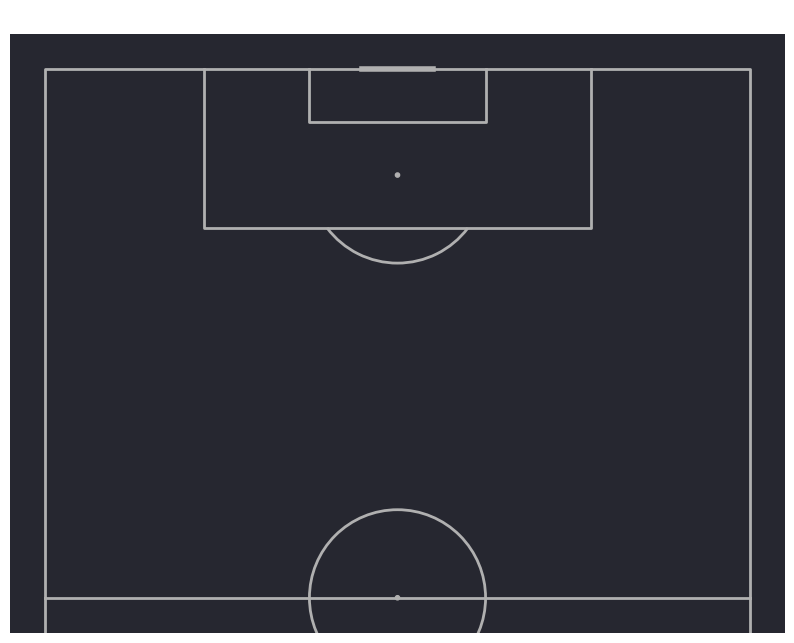

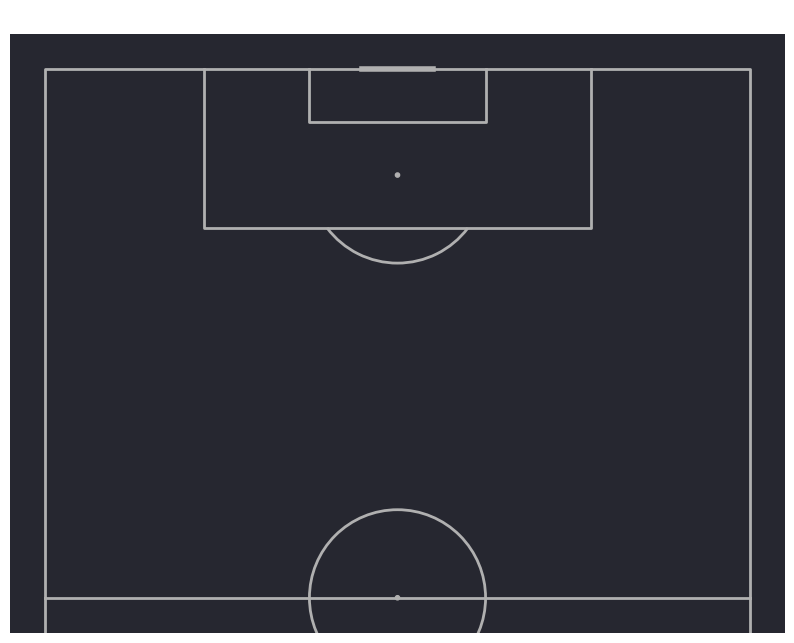

In [30]:
plot_match_shots_dual_separate(filtered_shots_df,h_team='Arsenal', a_team='Liverpool')

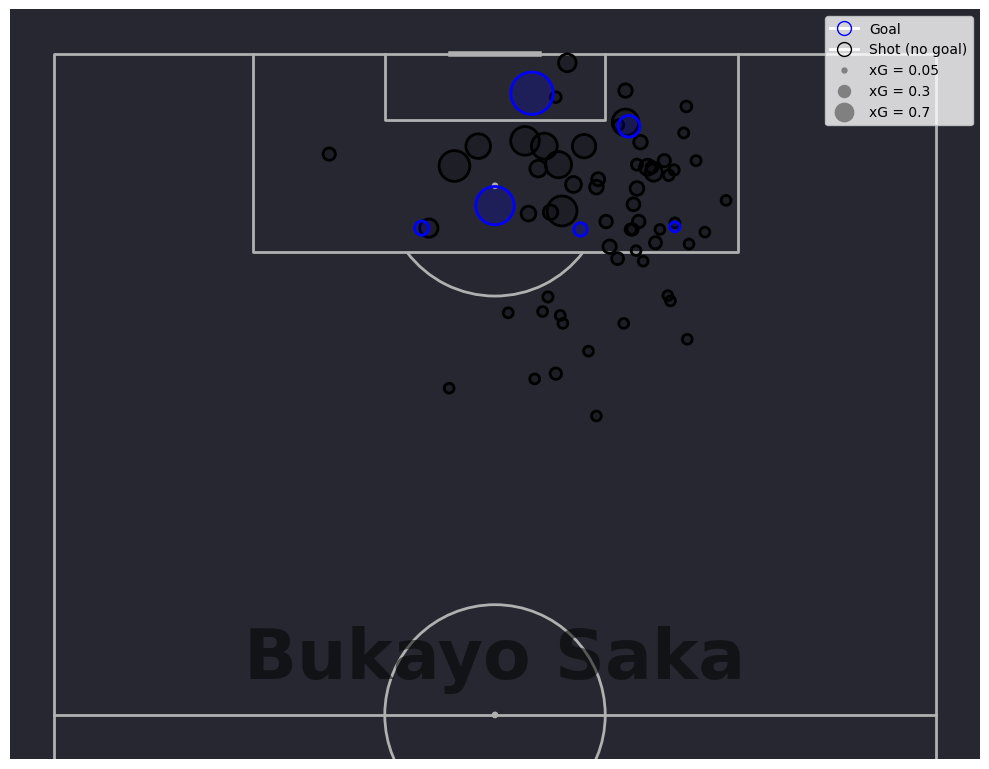

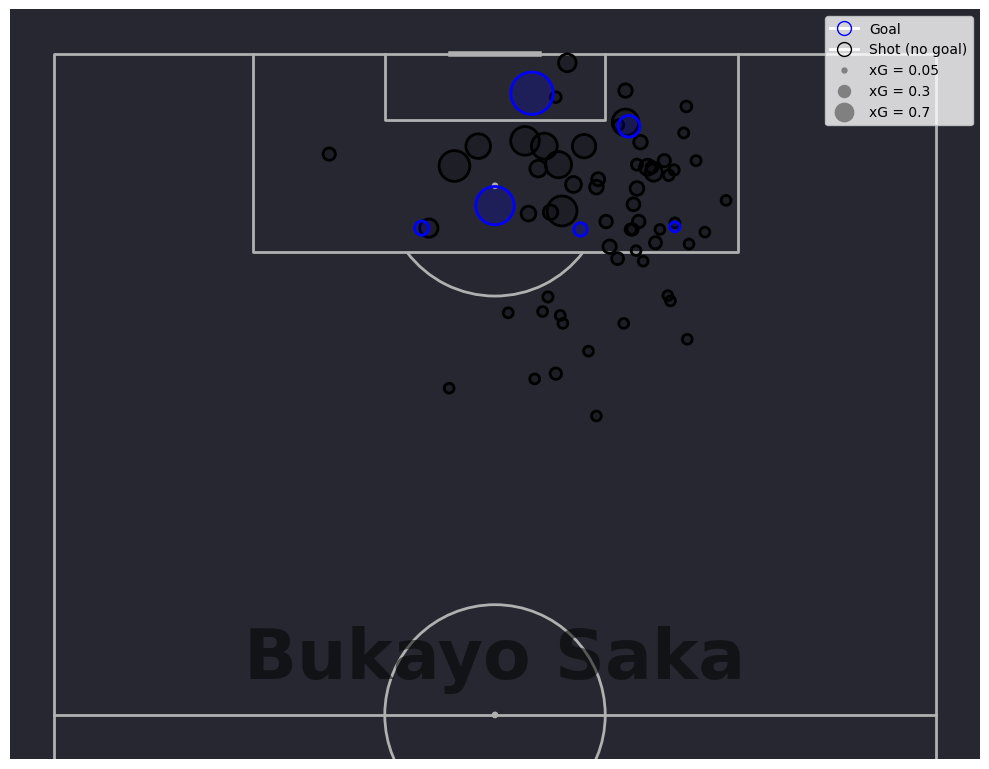

In [ ]:
plot_player_shots('Bukayo Saka', all_shots_df)